## **ATIVIDADE 6 - Classificação** 

**Grupo**: Tâmara Dallegrave, Marcus Silva, Daniel Neto, Paulo Brasil.



## **CONFIGURAÇÕES**



In [ ]:
#BIBLIOTECAS

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
import statistics
import datetime as dt
import calendar

%matplotlib inline

!pip install PyDrive
!pip install PyCaret

from sklearn.impute import SimpleImputer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from pycaret.classification import *

# IMPORTAÇÃO DB


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"138bRT5WPXfCdZj2fS_sMars4NlaQr75y"})
downloaded.GetContentFile('Sales2.csv')

In [ ]:
# CARREGANDO DB
df = pd.read_csv('Sales2.csv', sep=';', na_values='?')

df.head()


,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State
0,536329,137,0.15,1,2018-05-16 17:30:23.000,Pereira Barreto,SP
1,536329,136,1.38,1,2018-05-17 10:21:36.000,Pereira Barreto,SP
2,536329,135,1.00,1,2018-05-17 10:23:59.000,Pereira Barreto,SP
3,536329,135,10.00,1,2018-05-17 10:29:24.000,Pereira Barreto,SP
4,536329,136,0.79,1,2018-05-17 10:32:20.000,Pereira Barreto,SP


## **ANÁLISE DA DB**

In [ ]:
#PRÉ-PROCESSAMENTO DA BASE DE DADOS

#sns.heatmap(df.isna())
df['Timestamp']= pd.to_datetime(df['Timestamp'],format='%Y-%m-%d')
df['year']= df['Timestamp'].dt.year
df['month']= df['Timestamp'].dt.month
df['day']= df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.day_name()
df['PaymentMethod'] = np.where(df['PaymentMethod'] > 1, 'Credit Card', 'Cash')
#df = df.drop(columns='Timestamp')
df.head()

,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State,year,month,day,hour,Weekday
0,536329,137,0.15,Cash,2018-05-16 17:30:23,Pereira Barreto,SP,2018,5,16,17,Wednesday
1,536329,136,1.38,Cash,2018-05-17 10:21:36,Pereira Barreto,SP,2018,5,17,10,Thursday
2,536329,135,1.00,Cash,2018-05-17 10:23:59,Pereira Barreto,SP,2018,5,17,10,Thursday
3,536329,135,10.00,Cash,2018-05-17 10:29:24,Pereira Barreto,SP,2018,5,17,10,Thursday
4,536329,136,0.79,Cash,2018-05-17 10:32:20,Pereira Barreto,SP,2018,5,17,10,Thursday


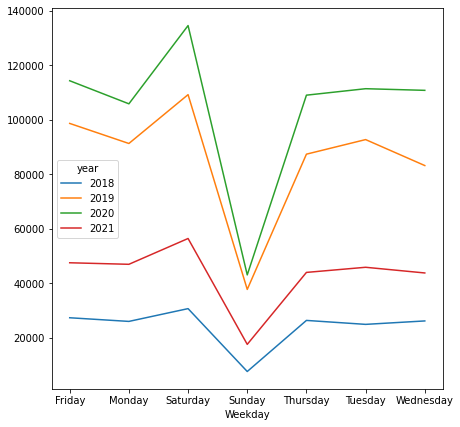

In [ ]:
#Gráfico de quantidade de vendas por dia da semana em cada ano
sales_of_weekDay_per_years = df.groupby(['Weekday'])['year'].value_counts()
sales_of_weekDay_per_years = sales_of_weekDay_per_years.unstack()
sales_of_weekDay_per_years.plot(kind='line',figsize=(7, 7))

## **PRÉ-PROCESSAMENTO**


No Pré-processamento foi analisado os dados da nossa base de dados para seleção de um cenário problema para classificação.

**Objetivo**: Classificação de dias entre bom e ruim dependendo da quantidade de vendas realizadas naquele dia. Para definição de bom foi utilizado o valor da média de vendas global, se o valor for igual ou maior a média este dia é considerado bom. Caso contrário, o dia é classificado como ruim.

In [ ]:
#CÁLCULO DE DIAS DA SEMANA (na base de dados)

'''
Verificação de quantos dias da semana existem na base de dados
'''

start = df['Timestamp'].min().strftime('%Y-%m-%d')
end = df['Timestamp'].max().strftime('%Y-%m-%d')

weekday = ['Sat', 'Fri', 'Tue', 'Mon', 'Thu', 'Wed', 'Sun']


qnt_weekday = []
for elem in weekday:
  qtd = np.busday_count(start, end, weekmask=elem)
  qnt_weekday.append((elem,qtd))

qnt_weekday



[('Sat', 165),
 ('Fri', 165),
 ('Tue', 165),
 ('Mon', 165),
 ('Thu', 165),
 ('Wed', 166),
 ('Sun', 165)]

In [ ]:
# Verificação das médias de venda por dia da semana

'''
Foi verificados que por dia da semana todas as médias possuiam um valor muito próximo como pode ser observado abaixo:
'''

new_df = df.groupby(['Weekday']).mean()
new_df

,Retailer,Pdv,Price,year,month,day,hour
Weekday,,,,,,,
Friday,538089.057481,807.580568,1.436795,2019.632351,6.340077,15.737554,14.354460
Monday,537978.334874,790.733766,1.412958,2019.643317,6.432045,15.140590,14.497455
Saturday,538175.865497,825.758482,1.459368,2019.654958,6.330709,15.504486,13.606340
Sunday,538598.211115,966.650301,1.454401,2019.666117,6.410297,15.093134,10.109233
Thursday,538027.522985,772.027119,1.420294,2019.639641,6.533230,15.482661,14.353384
Tuesday,537975.755145,782.149965,1.426888,2019.648270,6.564408,15.170060,14.325511
Wednesday,538025.576590,757.968895,1.425456,2019.652328,6.530606,15.327588,14.399437


In [ ]:
#CÁLCULO DE VENDAS (por dia da semana)
'''
Este era o algoritmo para calculo da média por dia da semana, este algoritmo foi descartado porque o classificador dividiu os dados de forma desbalanceada.

weekday_rec = df['Weekday'].value_counts()
weekday_mean = []
weekday_values = []
for elem in weekday_rec:
  weekday_values.append(elem)

i = 0
for elem, value in qnt_weekday:
    weekday_mean.append((elem,round(weekday_values[i]/value)))
    i += 1
weekday_mean
'''


"\nEste era o algoritmo para calculo da média por dia da semana, este algoritmo foi descartado porque o classificador dividiu os dados de forma desbalanceada.\n\nweekday_rec = df['Weekday'].value_counts()\nweekday_mean = []\nweekday_values = []\nfor elem in weekday_rec:\n  weekday_values.append(elem)\n\ni = 0\nfor elem, value in qnt_weekday:\n    weekday_mean.append((elem,round(weekday_values[i]/value)))\n    i += 1\nweekday_mean\n"

In [ ]:
#Verificar a quantidade de dias na base de dados
'''
Para média global foi contabilizado a quantidade total de dias da base de dados
'''

df_without_nulls = df.dropna()
totaldays = df_without_nulls['Weekday'].value_counts()
len(totaldays)

7

In [ ]:
#QUANTIDADE DE VENDAS (por dia)

df_class = df.resample('D', on='Timestamp')['Price'].sum().reset_index(name='Amount')
df_class2 = df[['Timestamp', 'Price']].groupby(pd.Grouper(key='Timestamp', freq='1D')).count()['Price']

#df.resample('D', on='Timestamp')['Price'].sum().value_counts().rename_axis('date').reset_index(name='count'))
df_class2

Timestamp
2018-05-16       1
2018-05-17     119
2018-05-18     296
2018-05-19     228
2018-05-20      93
              ... 
2021-07-11     396
2021-07-12    1115
2021-07-13    1095
2021-07-14    1019
2021-07-15      96
Freq: D, Name: Price, Length: 1157, dtype: int64

In [ ]:
#CRIAÇÃO DATAFRAME (com quantidade de vendas e valor total vendido por dia)

result = df_class.merge(df_class2, how='inner', on='Timestamp')
result = result.rename(columns={'Price': 'Qty'})

result['Timestamp'] = pd.to_datetime(result['Timestamp'],format='%Y-%m-%d')
result['Weekday'] = result['Timestamp'].dt.day_name()
result['Avg'] = result['Amount']/result['Qty']
#len(result) # 1157

# Remoção de dados nulos
result_without_NaN = result.dropna()

In [ ]:
# MÉDIA DE VENDAS GLOBAL
qty_days = len(result_without_NaN)
totalAmount = result_without_NaN['Amount'].sum()
totalAmount
day_avg_sold = round(totalAmount/qty_days)
day_avg_sold

2243

In [ ]:
#CRIAÇÃO DA COLUNA DE SAÍDA (DO CLASSIFICADOR)
result = result_without_NaN.drop(columns='Timestamp')
result['Analysis'] = np.where(result['Amount'] >= day_avg_sold, 'Good', 'Bad')

result.loc[result['Analysis'] == 'Bad']
result

,Amount,Qty,Weekday,Avg,Analysis
0,0.15,1,Wednesday,0.150000,Bad
1,156.34,119,Thursday,1.313782,Bad
2,370.60,296,Friday,1.252027,Bad
3,239.73,228,Saturday,1.051447,Bad
4,118.32,93,Sunday,1.272258,Bad
...,...,...,...,...,...
1152,1814.46,396,Sunday,4.581970,Bad
1153,4651.45,1115,Monday,4.171704,Good
1154,4578.15,1095,Tuesday,4.180959,Good
1155,4059.69,1019,Wednesday,3.983994,Good


In [ ]:
#CATEGORIZAÇÃO: Transformando campos não-numéricos em numéricos
le = preprocessing.LabelEncoder()
result['Weekday'] = le.fit_transform(result['Weekday'])
result['Analysis'] = le.fit_transform(result['Analysis'])

result.head()


,Amount,Qty,Weekday,Avg,Analysis
0,0.15,1,6,0.150000,0
1,156.34,119,4,1.313782,0
2,370.60,296,0,1.252027,0
3,239.73,228,2,1.051447,0
4,118.32,93,3,1.272258,0


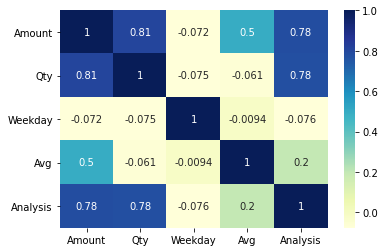

In [ ]:
# Correlação das features com o target(Analysis)
sns.heatmap(result.corr(), annot=True, cmap='YlGnBu')

## **CLASSIFICAÇÃO**

In [ ]:
### Selecionar variáveis de entrada e saída

x = result.drop(columns='Analysis') # x são das entradas
y = result['Analysis'] # y é a saída esperada


#NORMALIZAÇÃO
x = (x-x.min())/(x.max()-x.min())

### Definir dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

**Inferência do tipo de dados:**  Determinação dos tipos de dados correctos para todas as características. A função de configuração executa inferências essenciais sobre os dados e executa várias tarefas a jusante, tais como ignorar as colunas ID e Data, codificação categórica, imputação de valores em falta com base no tipo de dados inferidos pelo algoritmo interno do PyCaret. Esta função lista de todas as características e os seus tipos de dados inferidos.

In [ ]:
#SETUP 
'''

'''

exp_clf101 = setup(data = result, target = 'Analysis', session_id=123) 


,Description,Value
0,session_id,123
1,Target,Analysis
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1151, 5)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


## **Naive Bayes**

O algoritmo consiste em encontrar uma probabilidade a posteriori (possuir a doença, dado que recebeu um resultado positivo), multiplicando a probabilidade a priori (possuir a doença) pela probabilidade de “receber um resultado positivo, dado que tem a doença”. Porém, ele desconsidera completamente a correlação entre as variáveis (features). Ou seja, se determinada fruta é considerada uma “Maçã” se ela for “Vermelha”, “Redonda” e possui “aproximadamente 10cm de diâmetro”, o algoritmo não vai levar em consideração a correlação entre esses fatores, tratando cada um de forma independente.

Por possuir uma velocidade relativamente alta e precisar apenas de poucos dados para realizar a classificação, pode ser utilizado para previsões em tempo real. Este algoritmo é muito utilizado para filtragem de SPAM, Análise de Sentimento nas redes sociais (identificar se o usuário está feliz ou triste ao publicar determinado texto).



In [ ]:
## Naive Bayes
nb = GaussianNB()

## treinando classificador
nb.fit(X_train, y_train)

## testanto classificador
res_nb = nb.predict(X_test)

In [ ]:
print(classification_report(y_test, res_nb))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       141
           1       0.91      1.00      0.95       147

    accuracy                           0.95       288
   macro avg       0.96      0.95      0.95       288
weighted avg       0.96      0.95      0.95       288



### **KNeighborsClassifier**

É um algoritmo não paramétrico, aonde a estrutura do modelo será determinada pelo dataset utilizado. Este algoritmo também é conhecido como de aprendizado lento ou seja, não necessitam de dados de treinamento para se gerar o modelo, o que diminui em partes o processo inicial, mas em contrapartida gerará uma necessidade de analise posterior mais apurada. Todos os dados obtidos no dataset serão utilizados na fase de teste, resultando em um treinamento muito rápido e em um teste e validação lentos, momento o qual necessitamos estar bem atentos aos resultados gerados. 
É um classificador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. O treinamento é formado por vetores de n dimensões.

As etapas de um algoritmo KNN são:

```
1 — Recebe um dado não classificado;
2 — Mede a distância (Euclidiana, Manhattan, Minkowski ou Ponderada) do novo; dado com todos os outros dados que já estão classificados;
3 — Obtém as X(no caso essa variável X é o parâmetro K) menores distâncias;
4 — Verifica a classe de cada da um dos dados que tiveram a menor distância e conta a quantidade de cada classe que aparece;
5 — Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6 — Classifica o novo dado com a classe tomada como resultado da classificação

```



In [ ]:
from sklearn.pipeline import Pipeline
model_name = "KNeighborsClassifier"
knnClassifier = KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=2)
knnClassifier.fit(X_train, y_train)
y_pred_knn = knnClassifier.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       136
           1       0.99      0.99      0.99       152

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



### **Árvore de Decisão**
Uma árvore de decisão é formada por um conjunto de regras de classificação. Cada caminho da raiz até uma folha representa uma destas regras. A árvore de decisão deve ser definida de forma que, para cada observação da base de dados, haja um e apenas um caminho da raiz até a folha

In [ ]:
# Árvore de Decisão

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtc = dtc.fit(X_train, y_train)

res_dtc = dtc.predict(X_test)

print(classification_report(y_test, res_dtc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00       152

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



### **Regressão Logística**
É recomendada para situações em que a
variável dependente é de natureza dicotômica ou
binária. Quanto às independentes, tanto podem ser
categóricas ou não.

Busca estimar a probabilidade da variável
dependente assumir um determinado valor em
função dos conhecidos de outras variáveis.

Os resultados da análise ficam contidos no
intervalo de zero a um.

In [ ]:
# Regressão Logística
from sklearn.linear_model import LogisticRegression 
model_name = "Logistic Regression Classifier"
logisticRegressionClassifier = LogisticRegression(random_state=0,max_iter=1000)
logisticRegressionClassifier.fit(X_train,y_train)
y_pred_lrc = logisticRegressionClassifier.predict(X_test)
print(classification_report(y_test, y_pred_lrc))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       136
           1       0.94      0.99      0.97       152

    accuracy                           0.97       288
   macro avg       0.97      0.96      0.97       288
weighted avg       0.97      0.97      0.97       288



### **Comparação de Modelos**

In [ ]:
compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.481
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.094
dt,Decision Tree Classifier,0.9988,0.9988,0.9977,1.0000,0.9988,0.9975,0.9975,0.015
rf,Random Forest Classifier,0.9988,1.0000,0.9977,1.0000,0.9988,0.9975,0.9975,0.481
ada,Ada Boost Classifier,0.9988,0.9988,0.9977,1.0000,0.9988,0.9975,0.9975,0.017
gbc,Gradient Boosting Classifier,0.9988,0.9988,0.9977,1.0000,0.9988,0.9975,0.9975,0.099
knn,K Neighbors Classifier,0.9938,1.0000,0.9977,0.9911,0.9943,0.9874,0.9876,0.115
et,Extra Trees Classifier,0.9925,0.9998,0.9931,0.9933,0.9932,0.9850,0.9852,0.461
ridge,Ridge Classifier,0.9229,0.0000,0.9977,0.8793,0.9343,0.8421,0.8532,0.014
lda,Linear Discriminant Analysis,0.9229,0.9974,0.9977,0.8793,0.9343,0.8421,0.8532,0.016


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)